## Работа с геоданными

In [1]:
import pandas as pd
import numpy as np
import json 

from ipyleaflet import (
    Map,
    Marker, MarkerCluster,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    Popup,
    GeoJSON,
    DrawControl,
    basemaps, 
    Choropleth,
    AwesomeIcon)

from ipywidgets import HTML
from mpl_toolkits.basemap import Basemap

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline



#### 1. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.


In [2]:
data = pd.read_csv('taxi_agg_2016.csv') 

In [3]:
data_region = data.groupby('region').agg({'trips_number':'sum'}).reset_index() 
data_region.head() # в агрегированных данных информация только о регионах с ненулевым количеством поездок

,region,trips_number
0,14,1
1,15,1
2,24,1
3,26,1
4,31,19


In [4]:
regions = pd.read_csv("regions.csv", sep=";")
regions_lst = regions['region'].values

Создаю df, где была бы информация и о регионах с нулевыми поездками

In [5]:
n_lst = []
trip_dict = dict()
for i in regions_lst:
    number_of_trips = data_region.loc[(data_region['region']==i)]['trips_number'].values
    if number_of_trips.size > 0:
        number_of_trips = number_of_trips[0]
    else:
        number_of_trips = 0
    n_lst.append(number_of_trips)
    trip_dict[f'{i-1}'] = number_of_trips
d = {'region':regions_lst, 'trip_amount':n_lst}
new_data = pd.DataFrame(d)

In [6]:
new_data['trip_amount'].value_counts()

0       1283
1        252
2        115
3         74
5         42
        ... 
111        1
113        1
115        1
2176       1
3839       1
Name: trip_amount, Length: 347, dtype: int64

In [7]:
# количество регионов с нулевым количеством поездок
new_data['trip_amount'].value_counts()[0]

1283


#### 2. Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

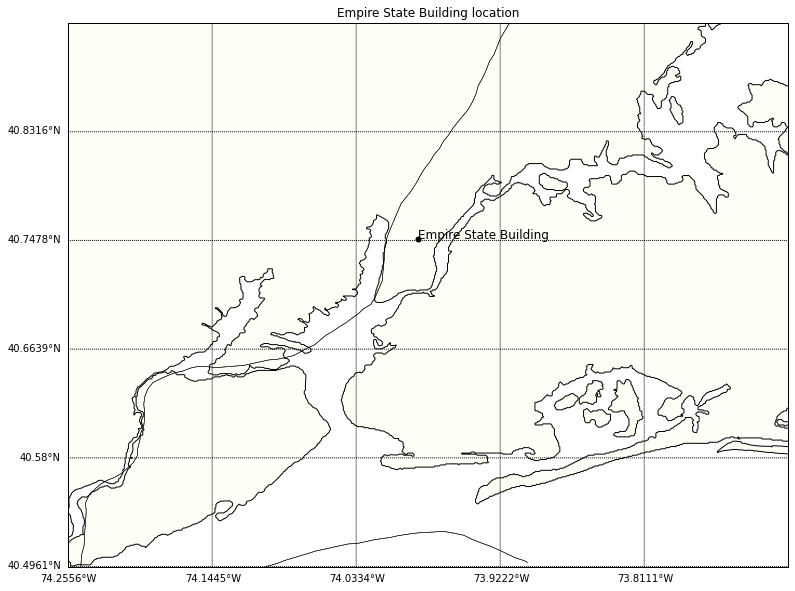

In [8]:
nyc_longitude_west = -74.25559
nyc_longitude_east = -73.70001
nyc_latitude_north = 40.91553
nyc_latitude_south = 40.49612

plt.figure(figsize=(15, 10))
map1 = Basemap(llcrnrlat= nyc_latitude_south, llcrnrlon= nyc_longitude_west, 
                 urcrnrlat= nyc_latitude_north, urcrnrlon= nyc_longitude_east,
                 resolution='f', projection='lcc',
                 lat_0 = (nyc_latitude_north + nyc_latitude_north)/2.0,
                 lon_0 = (nyc_longitude_west + nyc_longitude_east)/2.0, epsg=4326)

x, y = map1(-73.985428, 40.748817)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Empire State Building', fontsize=12);

map1.shadedrelief(scale=0.5)
map1.drawcoastlines()
map1.drawcountries()
map1.fillcontinents(color='ivory', alpha = 0.5)
map1.drawmapboundary()
map1.drawstates()

parallels = np.arange(nyc_latitude_south,nyc_latitude_north, (nyc_latitude_north - nyc_latitude_south)/5)
map1.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(nyc_longitude_west,nyc_longitude_east, (nyc_longitude_east - nyc_longitude_west)/5)
map1.drawmeridians(meridians,labels=[True,False,False,True])

plt.title('Empire State Building location')
plt.show()

#### 3. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

Text(0.5, 1.0, 'May 2016 Trips Count')

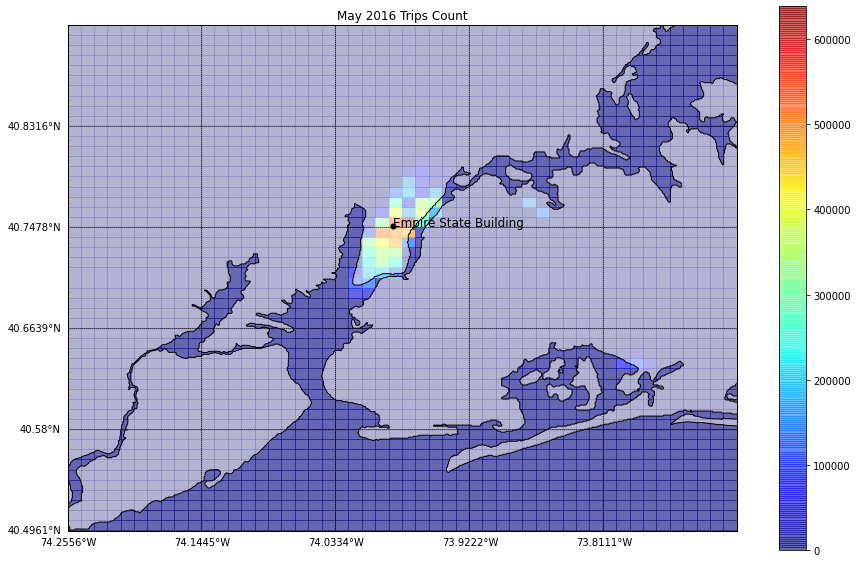

In [9]:
nyc_longitude_west = -74.25559
nyc_longitude_east = -73.70001
nyc_latitude_north = 40.91553
nyc_latitude_south = 40.49612

longs = np.unique(regions[['west', 'east']].values)
lats = np.unique(regions[['south', 'north']].values)
lon, lat = np.meshgrid(longs, lats)

plt.figure(figsize=(15, 10))
map2 = Basemap(llcrnrlat= nyc_latitude_south, llcrnrlon= nyc_longitude_west, 
                 urcrnrlat= nyc_latitude_north, urcrnrlon= nyc_longitude_east,
                 resolution='f', projection='lcc',
                 lat_0 = (nyc_latitude_north + nyc_latitude_north)/2.0,
                 lon_0 = (nyc_longitude_west + nyc_longitude_east)/2.0, epsg=4326)


map2.pcolormesh(lon, lat, new_data['trip_amount'].values.reshape(50,50).transpose(), latlon=True, cmap= 'jet', alpha = 0.6)
plt.colorbar()

x, y = map2(-73.985428, 40.748817)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Empire State Building', fontsize=12);

map2.drawcoastlines()
map2.drawcountries()
map2.fillcontinents(color='ivory', alpha = 0.5)
map2.drawmapboundary()

parallels = np.arange(nyc_latitude_south,nyc_latitude_north, (nyc_latitude_north - nyc_latitude_south)/5)
map2.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(nyc_longitude_west,nyc_longitude_east, (nyc_longitude_east - nyc_longitude_west)/5)
map2.drawmeridians(meridians,labels=[True,False,False,True])

plt.title('May 2016 Trips Count')

#### 4. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [10]:
nyc_longitude_west = -74.25559
nyc_longitude_east = -73.70001
nyc_latitude_north = 40.91553
nyc_latitude_south = 40.49612


m = Map(center=((nyc_latitude_south+nyc_latitude_north)/2, 
                (nyc_longitude_east+nyc_longitude_west)/2),zoom=12)

mark = Marker(location=[40.689247, -74.044502]) # Statue of Liberty
m += mark
m.layout.width = '70%'
m.layout.height = '500px'
m

Map(center=[40.705825, -73.9778], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

#### 5. Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [11]:
import branca.colormap as cm
geo_json_data = json.load(open('regions.json')) 

In [12]:
step = cm.StepColormap(['green','yellow', 'red'],
                       vmin = new_data['trip_amount'].min(), 
                       vmax = new_data['trip_amount'].max())

colors = step.to_linear()

nyc_longitude_west = -74.25559
nyc_longitude_east = -73.70001
nyc_latitude_north = 40.91553
nyc_latitude_south = 40.49612


layer = Choropleth(
    geo_data=geo_json_data,
    choro_data=trip_dict,
    colormap=colors,
    border_color='black',
    style={'fillOpacity': 0.5, 'dashArray': '5, 5', 'color':"black"},)

m = Map(center=((nyc_latitude_south+nyc_latitude_north)/2+0.05, (nyc_longitude_east+nyc_longitude_west)/2+0.009),
                zoom=12)
m.add_layer(layer)
m.layout.width = '70%'
m.layout.height = '700px'
m

Map(center=[40.755824999999994, -73.9688], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

#### 6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [13]:
data_region = data.groupby('region').agg({'trips_number':'mean'}).reset_index() # новая агрегация по среднему количеству поездок
data_region.head()

,region,trips_number
0,14,1.000000
1,15,1.000000
2,24,1.000000
3,26,1.000000
4,31,1.583333


Количество оставшихся ячеек:

In [14]:
data_region.loc[data_region['trips_number'] > 5].shape

(104, 2)

Все регионы выбраны корректно:

In [15]:
geo_json_data = json.load(open('regions_left.json')) # только соответствующие условию регионы

In [16]:
step = cm.StepColormap(['green','yellow', 'red'],
                       vmin = new_data['trip_amount'].min(), 
                       vmax = new_data['trip_amount'].max())

colors = step.to_linear()

nyc_longitude_west = -74.25559
nyc_longitude_east = -73.70001
nyc_latitude_north = 40.91553
nyc_latitude_south = 40.49612


layer = Choropleth(
    geo_data=geo_json_data,
    choro_data=trip_dict,
    colormap=colors,
    border_color='black',
    style={'fillOpacity': 0.5, 'dashArray': '5, 5', 'color':"black"},)

m = Map(center=((nyc_latitude_south+nyc_latitude_north)/2+0.05, (nyc_longitude_east+nyc_longitude_west)/2+0.009),
                zoom=12)
m.add_layer(layer)
m.layout.width = '70%'
m.layout.height = '700px'
m

Map(center=[40.755824999999994, -73.9688], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

#### 7. Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки). 